In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import json
from datetime import datetime, time

In [2]:
def check_folder(path, params, verbose = False):
    trees = list(itertools.product(params['year'], params['month'], params['day'],
                                   ['FundamentalData'], params['leadtime']))
    years = os.listdir(path)
    months = ["%02d" % (m,) for m in range(1,13)]
    days = ["%02d"% (d,) for d in range(1,32)]
    leadtimes = [f"FundamentalData_D-{str(l)}.csv" for l in range(1,16)]
    substitutes = [years, months, days, ['FundamentalData'], leadtimes]
    i = len(trees)
    while i>0:
        file = trees.pop(0)
        if '.' in file:
            files = []
            for j,el in enumerate(file):
                files.append([el] if el!='.' else substitutes[j])
            
            trees += list(itertools.product(*files))
        else:
            trees.append(file)
        i-=1    
        
    trees = list(map(lambda x: os.path.join(*x), trees))
    filtered_trees = [tree for tree in trees if os.path.isfile(os.path.join(path, tree))]
    if len(filtered_trees) < len(trees):
        print("Of the dates you have specified only %d are currently available." %(len(filtered_trees)) +\
              "To obtain which of them are missing, specifiy verbose = True")
        if verbose:
            print(list(set(trees) - set(filtered_trees)))
    return filtered_trees

def get_forecasts(path = "P:/CH/Weather Data/FUNDAMENTAL_DATA",
                  year = None,
                  month = None,
                  day = None,
                  leadtime = None,
                  model = None,
                  variable = None,
                  country = None,
                  run = None):
    date_params = {
        "year": [str(year) if  year is not None else '.'] if not isinstance(year, list) else [str(y) for y in year],
        "month": ["%02d" % (month,) if month is not None else '.'] if not isinstance(month, list) \
                                                                    else ["%02d" % (m,) for m in month], 
        "day": ["%02d" % (day,) if day is not None else '.'] if not isinstance(day, list) \
                                                                    else ["%02d" % (d,) for d in day],
        "leadtime": [f"FundamentalData_D-{str(leadtime)}.csv" if leadtime is not None else '.'] if not isinstance(leadtime, list) \
                                                            else [f"FundamentalData_D-{str(l)}.csv" for l in leadtime],
    }
    files = check_folder(path, date_params, verbose = False)
    forecast_df = []
    for file in files:
        df = pd.read_csv(os.path.join(path, file))
        df['values'] = df['values'].apply(lambda x: json.loads(x))
        df['flowdate'] = pd.to_datetime(df['flowdate'])
        df.drop('forecast_datetime', axis = 1, inplace = True)
        df['leadtime'] = int(file.split(".")[0][-1])
        df['hour'] = [list(range(0,24))]*len(df)
        if model is not None:
            df = df.loc[df['model'] == model if isinstance(model, str) else df['model'].isin(model)]
            
        if country is not None:
            df = df.loc[df['country'] == country if isinstance(country, str) else df['country'].isin(country)]
            
        if variable is not None:
            df = df.loc[df['fund_type'] == variable if isinstance(variable, str) else df['country'].isin(variable)]
            
        if run is not None:
            df = df.loc[df['run'] == int(run)]
        
        if df.empty:
            print("File %s does not contain any element satisfying the query" %file)
            continue
            
        lst_col = ['values', 'hour']
        df = pd.DataFrame({
            col:np.repeat(df[col].values, 24)
            for col in df.columns.difference(lst_col)
         }).assign(**{col:np.concatenate(df[col].values) for col in lst_col})[df.columns.tolist()]
        
        df['date'] = df.apply(lambda x: datetime.combine(x['flowdate'], time(x['hour'],0)), axis =1)
        df.set_index('date', inplace = True)
        df.drop(['flowdate', 'hour'], axis = 1, inplace = True)
        
        forecast_df.append(df)
    
    return pd.concat(forecast_df).dropna(how="all",axis=1) 

In [8]:
df = get_forecasts(year = 2021, month = [6,7,8,9], day = 30, model = None, variable = "Wind", country = "DE", run = 12)


Of the dates you have specified only 48 are currently available.To obtain which of them are missing, specifiy verbose = True
['2021\\09\\30\\FundamentalData\\FundamentalData_D-2.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-15.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-8.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-6.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-11.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-13.csv', '2021\\07\\30\\FundamentalData\\FundamentalData_D-2.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-12.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-9.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-7.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-10.csv', '2021\\06\\30\\FundamentalData\\FundamentalData_D-14.csv']
File 2021\06\30\FundamentalData\FundamentalData_D-1.csv does not contain any element satisfying the query
File 2021\07\30\FundamentalData\FundamentalData_D-1.csv does not c

In [53]:
df = pd.read_csv('SELMA-FILE.csv', header = 0, index_col = [0,1], sep = ';')
df.reset_index(level = 1, drop = True, inplace = True)
df.drop([col for col in df.columns if 'GFS' in col ] + ['Wind power highest recorded Germany National (GW) [30/11/2021]', 'Observation Germany National (GW)', 'Installed capacity Germany National (GW)', 'Forecast Meteologica Germany National (GW)'], axis = 1, inplace = True)
df.index = pd.to_datetime(df.index, format = '%d/%m/%Y %H:%M')
df

,Average forecast ECMWF ENS Germany National (GW),Forecast ECMWF HRES Germany National (GW),Scenario 0 forecast ECMWF ENS Germany National (GW),Scenario 1 forecast ECMWF ENS Germany National (GW),Scenario 2 forecast ECMWF ENS Germany National (GW),Scenario 3 forecast ECMWF ENS Germany National (GW),Scenario 4 forecast ECMWF ENS Germany National (GW),Scenario 5 forecast ECMWF ENS Germany National (GW),Scenario 6 forecast ECMWF ENS Germany National (GW),Scenario 7 forecast ECMWF ENS Germany National (GW),...,Scenario 41 forecast ECMWF ENS Germany National (GW),Scenario 42 forecast ECMWF ENS Germany National (GW),Scenario 43 forecast ECMWF ENS Germany National (GW),Scenario 44 forecast ECMWF ENS Germany National (GW),Scenario 45 forecast ECMWF ENS Germany National (GW),Scenario 46 forecast ECMWF ENS Germany National (GW),Scenario 47 forecast ECMWF ENS Germany National (GW),Scenario 48 forecast ECMWF ENS Germany National (GW),Scenario 49 forecast ECMWF ENS Germany National (GW),Scenario 50 forecast ECMWF ENS Germany National (GW)
Timestamp start,,,,,,,,,,,,,,,,,,,,,
2021-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03 01:00:00,22.12,22.08,22.19,22.25,21.99,20.72,23.17,21.27,22.01,22.99,...,23.14,23.29,22.57,21.53,21.54,22.75,21.61,22.30,22.24,22.09
2021-12-03 02:00:00,22.65,22.69,22.74,22.47,22.03,21.27,23.24,22.57,22.24,22.51,...,24.42,24.14,22.97,22.54,20.59,23.47,22.28,22.70,22.96,22.99
2021-12-03 03:00:00,23.42,23.47,23.52,22.89,22.56,21.59,23.26,23.29,22.95,23.06,...,25.45,24.89,23.40,23.57,21.31,24.97,23.06,24.01,24.20,23.13
2021-12-03 04:00:00,24.33,24.37,24.48,23.39,23.09,22.17,23.56,24.36,23.99,23.92,...,26.43,25.16,24.25,25.26,22.67,26.18,24.06,25.86,25.46,23.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17 19:00:00,18.53,NaN,19.46,9.19,7.69,4.54,3.67,44.95,22.69,12.61,...,6.90,42.15,3.46,30.51,44.10,22.90,10.00,29.76,31.12,14.52
2021-12-17 20:00:00,18.50,NaN,19.08,8.84,7.58,5.08,3.76,44.76,24.36,12.39,...,7.03,43.62,3.59,29.95,44.23,22.09,9.40,28.76,31.38,15.29
2021-12-17 21:00:00,18.29,NaN,19.08,8.29,7.48,5.64,4.04,44.35,25.67,11.50,...,7.04,44.76,3.73,29.18,44.02,21.23,8.45,27.63,31.31,15.88


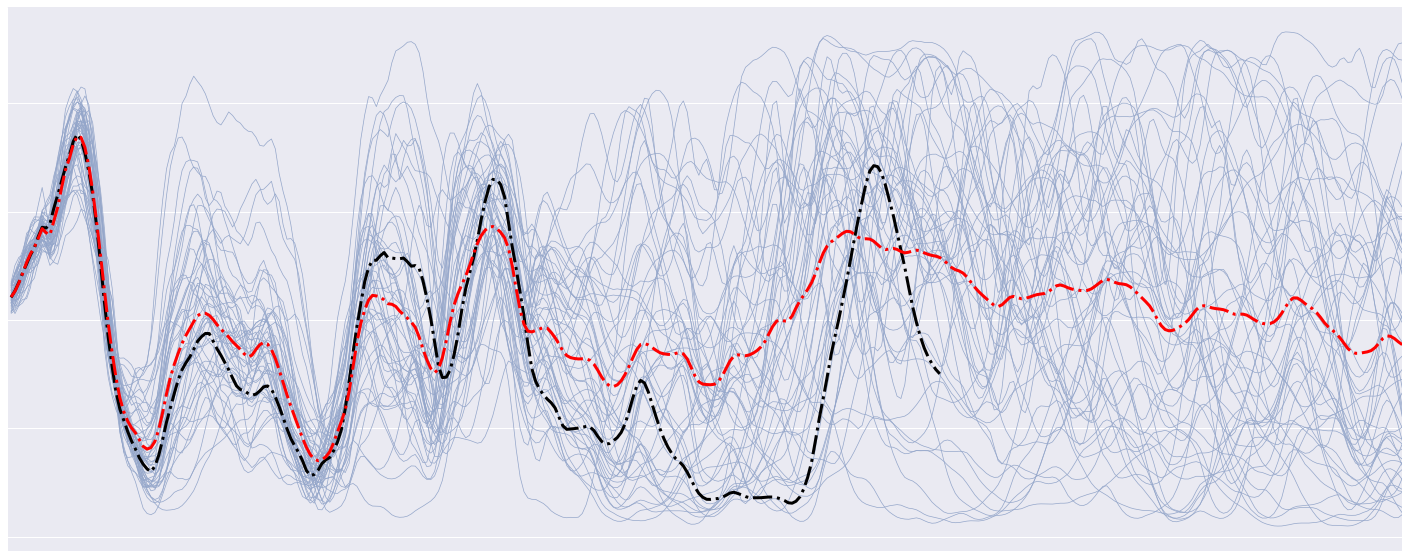

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", rc={"axes.labelsize":16,"axes.titlesize":20, "legend.fontsize":16})
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1, figsize = (25,10))
for scenario in range(0, 51):
    df['Scenario %d forecast ECMWF ENS Germany National (GW)' %scenario].plot(kind = 'line', linewidth = 0.7, ax = ax, color = '#94a6ca')
df['Forecast ECMWF HRES Germany National (GW)'].plot(kind = 'line', linewidth = 3, linestyle = '-.', ax = ax, color = 'k', label = 'Op Model')
df['Average forecast ECMWF ENS Germany National (GW)'].plot(kind = 'line', linewidth = 3, linestyle = '-.', ax = ax, color = 'r', label = 'Ens Model - Mean')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
ax.set_xlabel("")
plt.show()

# GFS Retrieval

In [1]:
import getgfs
f=getgfs.Forecast("0p25")
f.search("wind")

[('gustsfc', '** surface wind speed (gust) [m/s] ', 100),
 ('ugrdprs',
  '** (1000 975 950 925 900.. 10 7 4 2 1) u-component of wind [m/s] ',
  125),
 ('ugrd_1829m',
  '** 1829 m above mean sea level u-component of wind [m/s] ',
  125),
 ('ugrd_2743m',
  '** 2743 m above mean sea level u-component of wind [m/s] ',
  125),
 ('ugrd_3658m',
  '** 3658 m above mean sea level u-component of wind [m/s] ',
  125),
 ('ugrd10m', '** 10 m above ground u-component of wind [m/s] ', 125),
 ('ugrd20m', '** 20 m above ground u-component of wind [m/s] ', 125),
 ('ugrd30m', '** 30 m above ground u-component of wind [m/s] ', 125),
 ('ugrd40m', '** 40 m above ground u-component of wind [m/s] ', 125),
 ('ugrd50m', '** 50 m above ground u-component of wind [m/s] ', 125),
 ('ugrd80m', '** 80 m above ground u-component of wind [m/s] ', 125),
 ('ugrd100m', '** 100 m above ground u-component of wind [m/s] ', 125),
 ('ugrdsig995', '** 0.995 sigma level u-component of wind [m/s] ', 125),
 ('ugrd30_0mb', '** 30-0

In [59]:
import numpy as np
import xarray as xr
import pandas as pd
import itertools
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.io.shapereader as shpreader

In [4]:
# File Details
# TODO: pass as arguments to the script
dt = '20211208'
res = 25
step = '1hr'
run = '{:02}'.format(0)
lat_toplot = np.arange(20, 80.25, 0.25) # last number is exclusive
lon_toplot = np.arange(-90, 30.25, 0.25) # last number is exclusive

URL = f'http://nomads.ncep.noaa.gov:80/dods/gfs_0p{res}_{step}/gfs{dt}/gfs_0p{res}_{step}_{run}z'

variables = ['ugrd10m', 'vgrd10m']

dataset = xr.open_dataset(URL)[variables]
dataset.to_netcdf(f"P:\\CH\Weather Data\\GFS/gfs_0p{res}_{dt}_{step}_{run}z.nc")
dataset = xr.open_dataset(f"P:\\CH\Weather Data\\GFS/gfs_0p{res}_{dt}_{step}_{run}z.nc")

dataset['wind speed'] = np.sqrt(dataset['ugrd10m']**2 + dataset['vgrd10m']**2)
dataset = dataset.assign_coords(lon=(((dataset.lon + 180) % 360) - 180)).sortby('lon')
wind_eu = dataset.sel(lon = lon_toplot, lat = lat_toplot)

c:\python36\lib\site-packages\xarray\coding\times.py:83: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [14]:
wind_eu['wind speed']

<xarray.DataArray 'wind speed' (time: 121, lat: 241, lon: 481)>
array([[[ 2.4071648 ,  1.8146808 ,  1.7155806 , ...,  5.5667114 ,
          5.662199  ,  5.91023   ],
        [ 1.9956219 ,  1.7126663 ,  1.783882  , ...,  7.262274  ,
          6.3046045 ,  6.0715547 ],
        [ 1.326093  ,  1.2298416 ,  1.8402402 , ...,  8.772627  ,
          8.203053  ,  6.889268  ],
        ...,
        [ 2.3650513 ,  1.6809499 ,  1.5981507 , ...,  6.6582565 ,
          6.5140476 ,  6.3980675 ],
        [ 2.4707928 ,  2.6164472 ,  2.6961887 , ...,  8.407181  ,
          7.8414645 ,  7.400769  ],
        [ 1.7331258 ,  1.5515254 ,  1.4427367 , ...,  9.26038   ,
          9.030772  ,  8.783873  ]],

       [[ 2.5167577 ,  2.3971884 ,  2.1613126 , ...,  7.6837    ,
          7.822145  ,  7.7422    ],
        [ 1.9253953 ,  1.7147939 ,  2.3027225 , ...,  8.721893  ,
          8.577198  ,  8.26185   ],
        [ 1.6214364 ,  1.3486961 ,  1.6423308 , ...,  9.952876  ,
          9.098563  ,  8.6637745 ],
...
        [ 3.5622907 ,  3.047622  ,  1.9879518 , ...,  3.8865716 ,
          3.86535   ,  3.9494588 ],
        [ 3.3273828 ,  2.8270319 ,  2.5085752 , ...,  9.324765  ,
          8.124982  ,  7.0079293 ],
        [ 2.451101  ,  1.870449  ,  1.3656828 , ..., 11.064994  ,
         10.6547575 , 10.34752   ]],

       [[ 1.1026094 ,  0.71816   ,  1.5951396 , ...,  4.8720503 ,
          5.323392  ,  6.410566  ],
        [ 0.71513534,  1.0074927 ,  1.4096156 , ...,  5.4601455 ,
          5.734562  ,  6.1104574 ],
        [ 0.9800633 ,  2.0099335 ,  1.7648727 , ...,  6.4484596 ,
          5.5851192 ,  5.1057734 ],
        ...,
        [ 3.6354125 ,  3.090282  ,  2.055625  , ...,  7.6026363 ,
          7.0606613 ,  6.4609075 ],
        [ 3.309307  ,  2.8683906 ,  2.6175747 , ..., 10.094428  ,
          9.677781  ,  9.2387705 ],
        [ 2.564329  ,  1.9919766 ,  1.4941438 , ..., 10.842775  ,
         10.354373  ,  9.762176  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-12-08 2021-12-08 ... 2021-12-13
  * lat      (lat) float64 20.0 20.25 20.5 20.75 21.0 ... 79.25 79.5 79.75 80.0
  * lon      (lon) float64 -90.0 -89.75 -89.5 -89.25 ... 29.25 29.5 29.75 30.0

In [45]:
def plot_map(dt):
    xlim, ylim = (dt['lon'].values.min(), dt['lon'].values.max()), \
                     (dt['lat'].values.min(), dt['lat'].values.max())
    trans = ccrs.PlateCarree()
    proj = ccrs.LambertConformal((xlim[1] + xlim[0]) / 2, (ylim[1] + ylim[0]) / 2)
    vmin = dt.quantile(.05).values
    vmax = dt.quantile(.95).values
    fig, ax = plt.subplots(1, 1, figsize=(7, 7),
                           subplot_kw={'projection': proj})
    cset = dt.plot.contourf(x="lon", y="lat", ax=ax, levels=50, alpha=.7,
                                transform=trans, cmap="RdBu_r",
                                norm=mpl.colors.SymLogNorm(vmin=vmin, vmax=vmax,
                                linthresh=max(dt.quantile(.85), 10), base=10),
                                cbar_kwargs=dict(orientation='horizontal', extend='both',
                                                 ticks=[vmin, vmax], format="%d"))

    ax.coastlines()
    rect = mpl.path.Path([[xlim[0], ylim[0]],
                          [xlim[1], ylim[0]],
                          [xlim[1], ylim[1]],
                          [xlim[0], ylim[1]],
                          [xlim[0], ylim[0]],
                          ]).interpolated(20)
    proj_to_data = trans._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_extent([xlim[0], xlim[1], ylim[0] - 10, ylim[1]])

    plt.show()
    
def get_country(country_code, dt):
    fname = f"P:\\CH\\Weather Data\\SHP_FILES\\gadm36_{country_code}_shp\\gadm36_{country_code}_0.shp"
    shapes = list(shpreader.Reader(fname).geometries())
    x0, y0, x1, y1 = shapes[0].bounds
    print(x0, x1, y0, y1)
    return dt.where(np.logical_and(np.logical_and(dt['lon'] >= x0, dt['lon'] <= x1),np.logical_and(dt['lat'] >= y0, dt['lat'] <= y1)), drop = True)

In [ ]:
for i in range(121):
    plot_map(wind_eu['wind speed'].isel(time = i))

6.63087893 18.52069473 35.49291611 47.09096146


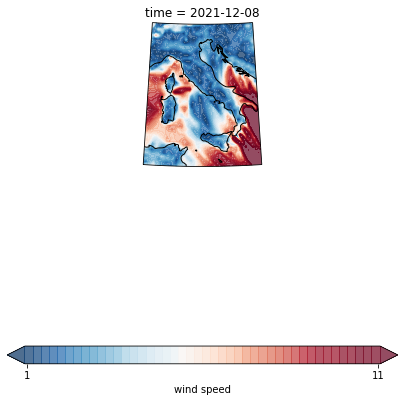

In [49]:
plot_map(get_country('ITA', wind_eu)['wind speed'].isel(time = 0))

In [72]:
country_code = 'ITA'
fname = f"P:\\CH\\Weather Data\\SHP_FILES\\gadm36_{country_code}_shp\\gadm36_{country_code}_0.shp"
shapes = list(shpreader.Reader(fname).geometries())

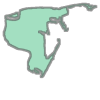

In [88]:
[poly for poly in shapes[0]][-2]